<a href="https://colab.research.google.com/github/Asfilcnx3/Project3_Digits/blob/main/Digits_Proyecto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Haremos una CNN pequeña para usarla en el dataset "Digits"

## Este será un dataset muy simple y usaremos capas convolucionales y de maxpool

In [1]:
# Importamos todos lo necesario
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

(1797, 64)


<Figure size 640x480 with 0 Axes>

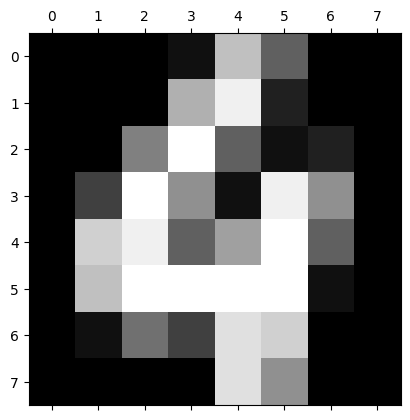

In [2]:
# No podremos trabajar con un dataframe para explorar los datos actuales

digits = load_digits()
print(digits.data.shape)

# Hacemos una visualización de los datos con los que trabajamos
plt.gray()
plt.matshow(digits.images[-9])
plt.show()

In [3]:
# Separamos el dataset en "X" y "y"
X, y = load_digits(return_X_y=True) # el dataset ya nos dá la opción

# Separaramos en datasets de entrenamiento, validación y prueba
X_train, X_test_raw, y_train, y_test_raw = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    random_state=42
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_raw,
    y_test_raw,
    stratify=y_test_raw,
    test_size=0.5,
    random_state=42
)
print("-----"*10)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

# Transformamos los datos a tensores para poder trabahar con estos
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print("-----"*10)
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)
print(X_val_tensor.shape)
print(y_val_tensor.shape)

--------------------------------------------------
(1257, 64)
(1257,)
(270, 64)
(270,)
(270, 64)
(270,)
--------------------------------------------------
torch.Size([1257, 64])
torch.Size([1257])
torch.Size([270, 64])
torch.Size([270])
torch.Size([270, 64])
torch.Size([270])


### La red neuronal convolucional llevará la siguiente arquitectura:

`Capa Convolucional -> Maxpool -> Capa Convolucional -> Maxpool -> Flatten -> Dense -> Dense`

--------------------------------------------------
Epoch: 10, Loss: 2.073, Val Loss: 2.029, Val Acc: 48.5185%
--------------------------------------------------
--------------------------------------------------
Epoch: 20, Loss: 1.633, Val Loss: 1.551, Val Acc: 77.4074%
--------------------------------------------------
--------------------------------------------------
Epoch: 30, Loss: 1.05, Val Loss: 0.967, Val Acc: 85.9259%
--------------------------------------------------
--------------------------------------------------
Epoch: 40, Loss: 0.657, Val Loss: 0.603, Val Acc: 89.2593%
--------------------------------------------------
--------------------------------------------------
Epoch: 50, Loss: 0.462, Val Loss: 0.426, Val Acc: 88.5185%
--------------------------------------------------
--------------------------------------------------
Epoch: 60, Loss: 0.326, Val Loss: 0.303, Val Acc: 92.9630%
--------------------------------------------------
-----------------------------------

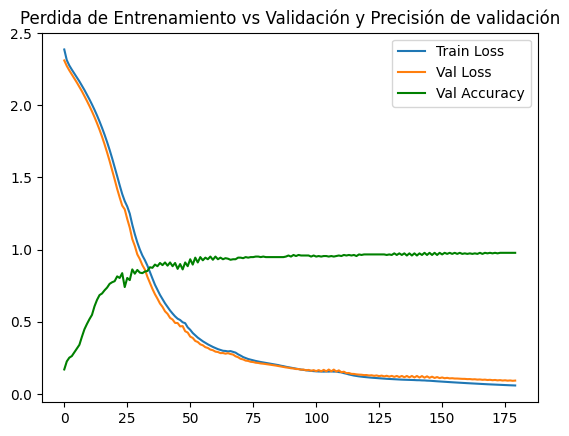

In [4]:
# Vamos a crear la CNN (Convolutional Neural Network)
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 8, 64)
    self.out = nn.Linear(64, 10) # 10 salidas por las 10 categorías diferentes

  def forward(self, x):
    x = x.view(-1, 1, 8, 8)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    return self.out(x)
model = CNN()

# Creamos los parametros
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

# Creamos la función de entrenamiento junto con su bucle

epochs = 180
val_looses = []
val_accs = []
losses = []

for epoch in range(epochs):
  model.train()
  outputs = model(X_train_tensor)
  loss = loss_fn(outputs, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

  model.eval()
  with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = loss_fn(val_outputs, y_val_tensor)
    _, val_predicted = torch.max(val_outputs, 1)
    val_acc = accuracy_score(y_val_tensor.numpy(), val_predicted.numpy())
    val_looses.append(val_loss.item())
    val_accs.append(val_acc)

  if (epoch+1) % 10 == 0:
    print("-----"*10)
    print(f"Epoch: {epoch+1}, Loss: {round(loss.item(),3)}, Val Loss: {round(val_loss.item(),3)}, Val Acc: {val_acc*100:.4f}%")
    print("-----"*10)
    # Sin mejora a partir de la época 170


# Visualizamos los datos de entrenamiento vs validación
plt.plot(losses, label="Train Loss")
plt.plot(val_looses, label="Val Loss")
plt.title("Pérdida entrenamiento vs Validación")
plt.plot(val_accs, label="Val Accuracy", color='green')
plt.title("Perdida de Entrenamiento vs Validación y Precisión de validación")
plt.legend()
plt.show()

--------------------------------------------------
Accuracy: 98.1481%
--------------------------------------------------


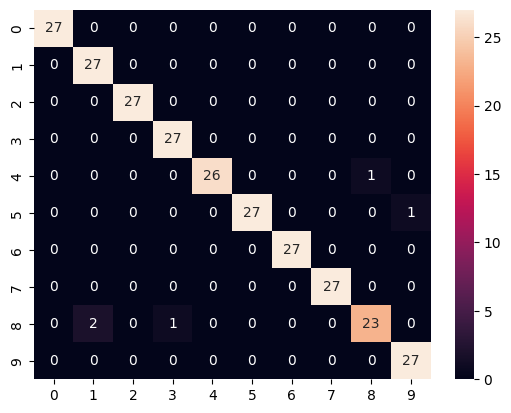

In [5]:
# Evaluando con los el set de prueba
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print("-----"*10)
    print(f'Accuracy: {acc*100:.4f}%')
    print("-----"*10)


# Creamos su matriz de confusión
cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
sns.heatmap(cm, annot=True, fmt='d')
plt.show()